In [201]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import math
import codecs
from collections import Counter
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec
import spacy
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import ast

from feature_extraction import TextFeatureCreator

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [2]:
#import zipfile
#zip_ref = zipfile.ZipFile("clean_newsela_article_files.zip", 'r')
#zip_ref.extractall("clean_newsela")
#zip_ref.close()

In [4]:
nlp = spacy.load('en_core_web_sm')

# Attention Based Neural Networks

## Import Section

### Dataset

In [4]:
#import training and test set
df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores_V2.csv",sep=";")
df = df.loc[~df["path"].str.contains("LSAT")]
len(df)

21490

### Text Scorer

In [5]:
#import Scorer
ts = TextFeatureCreator("/data/ts_cost_function/LSATtexts.txt")

In [6]:
ts.feature_max

array([4.60611227e+00, 3.10202027e+01, 3.18078798e-01, 4.72160037e+01,
       4.57929050e-01, 7.43301324e+00, 4.42320513e+00, 2.82743677e+00,
       1.52766676e+00, 1.39530366e+00, 1.08050328e+00, 6.62886357e-01,
       1.08484166e+00, 1.20740261e-01, 3.11994654e-01, 1.65647696e-02,
       1.52961211e+00, 1.98660670e-01, 3.44356431e+00, 3.82638558e+00])

## Explore Dataset

### Number of different Tokens

In [7]:
test_path = "/data/ts_cost_function/clean_newsela/"
#test_path = test_path[:5] + "clean_" + test_path[5:]

In [8]:
def yield_file_text(df):
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            yield get_file_text(row,tokenize=False)

In [9]:
def get_file_text(row,tokenize=True):
    path = row["path"].split("/")[-1]
    path= "/data/ts_cost_function/clean_newsela/"+path
    #if row["dataset"] == "newsela":
    #    path = row["path"][:5] + "clean_" + row["path"][5:]
    with codecs.open(path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        if tokenize:
            text = [[word.text.lower() for word in nlp(sent)] for sent in text.split(".")]
        return text

In [10]:
def load_eng_words(eng_words_path="data/20k_words.txt"):

    with open(eng_words_path,"r") as f:
        data = f.read()
        words = data.split("\n")
        english_df = pd.DataFrame(data=words,columns=["word"])
        english_df["index"] = range(0,len(english_df))
    return english_df

In [ ]:
texts = [get_file_text(row) for ind,row in tqdm(df.iterrows()) if row["path"] != 'data/LSATtexts.txt']

In [ ]:
#word_set = set()
counter = Counter()
for ind,row in tqdm(df.iterrows()):
    lem_text = [token.lemma_ for token in nlp(get_file_text(row))]
    counter.update(lem_text)

In [23]:
with open("data/newsela_word_set.txt","w") as f:
    f.write(",".join(word_set))
    f.close()

In [47]:
word_array = np.array(list(word_set))
english_df = load_eng_words()
len(word_set.intersection(english_df["word"].values))

15419

### Number of Sentences and Words per Sentence

In [11]:
def sentence_stats(df):
    sents = []
    words = []
    removed = []
    for ind,text in enumerate(yield_file_text(df)):
        sent_split = sent_tokenize(text)
        sents.append(len(sent_split))
        words.append([word_tokenize(sent) for sent in sent_split])
        if text.find("This article has been removed") >= 0:
            removed.append(ind)
    
    print("Max #Sents: {}".format(np.max(sents)))
    print("Min #Sents: {}".format(np.min(sents)))
    print("Std #Sents: {}".format(np.std(sents)))
    plt.boxplot(sents)
    plt.show()
    
    return sents,words,removed

Max #Sents: 204
Min #Sents: 11
Std #Sents: 12.270055057859112


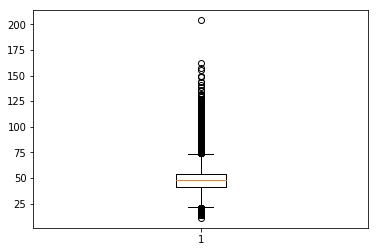

In [37]:
sents,words,removed = sentence_stats(df)

In [41]:
#Max Word Count
np.max([np.max(article) for article in words])

ValueError: zero-size array to reduction operation maximum which has no identity

In [110]:
#Mean Word Count
np.mean([sent for art in words for sent in art])

14.720281280318863

# Input Data

## Add lemmatize text to feature scores

In [65]:
def create_dataset_file(df,transform_fn,tokenize=False):
    df["text"] = df.apply(lambda row: transform_fn(get_file_text(row,tokenize)),axis=1)
    return df["text"]

In [66]:
def lemmatize_text(text):
    lemma_text=[]
    lemma_sent = []
    for token in nlp(text.lower()):
        if token.is_sent_start == True:
            lemma_text.append(lemma_sent)
            lemma_sent = []
        if token.lemma_ != "-PRON-":
            lemma_sent.append(token.lemma_)
        else:
            lemma_sent.append(token.text)
    return lemma_text
    

In [ ]:
df["text"] = create_dataset_file(df,lemmatize_text,False)

In [123]:
df.to_csv("/data/ts_cost_function/dataset_features_and_text.csv",index=False,sep="|")

## Word Embedding

In [5]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")

### train word2vec

In [7]:
def prepare_sent_for_word2vec(text_list):
    text_parts,text_part = [],[]
    text_part_len = 0
    for text in text_list:
        text_len = len(text)
        if text_part_len + text_len < 900000:
            text_part_len += text_len
            text_part += [text]
        else:
            text_parts += [" ".join(text_part)]
            text_part_len = 0
            text_part = []
    return text_parts
    

In [ ]:
text_list = df["text"].values
text_parts = prepare_sent_for_word2vec(text_list)

hole_lem_text = [lemmatize_text(text) for text in tqdm(text_parts)]
hole_text_sents = np.concatenate(hole_lem_text)

In [104]:
lem_word2vec_model = Word2Vec(hole_text_sents, size=50, window=4, min_count=5)

In [107]:
lem_word2vec_model.save("/data/ts_cost_function/word2vec_lem.model")

In [109]:
lem_word2vec_model.wv["do"]

array([ 1.2452955 , -2.1530788 ,  1.7280709 , -0.9999138 , -1.1060853 ,
        0.3383382 , -1.1418934 ,  2.2745516 , -0.2513405 , -0.82757384,
       -0.7249763 ,  1.7150258 ,  2.44857   , -3.9633307 , -1.7148128 ,
       -0.02097538,  4.4459324 ,  0.41563603,  0.43043882, -0.21437858,
       -2.0976083 ,  3.0210202 ,  0.19070254,  2.732013  , -0.02442212,
        3.6682212 ,  0.86653304,  1.7804645 , -0.8916921 ,  2.6753292 ,
       -0.75225073, -2.1348693 ,  1.1207342 , -1.9519628 ,  1.996752  ,
       -2.7731352 ,  1.3074355 ,  3.1944182 , -2.046747  , -0.01732185,
       -0.9517765 ,  0.7973166 ,  0.5044691 , -1.0322701 ,  3.7471695 ,
       -0.25170118,  2.2080932 , -3.2449086 , -3.4603064 , -0.67942697],
      dtype=float32)

## Exchange lemmatized text by word2vec vectors

In [202]:
df.iloc[:5].apply(lambda x: ast.literal_eval(x["text"]),axis=1)

0    [[one, of, the, big, threat, to, the, kea, be,...
1    [[drone, help, keep, swimmer, and, surfer, saf...
2    [[a, california, company, have, make, old, tim...
3    [[the, drama, teacher, at, the, parkland, ,, f...
4    [[he, be, the, first, democrat, to, be, elect,...
dtype: object

In [203]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")
df["text"] = df.apply(lambda x: ast.literal_eval(x["text"]),axis=1)
df.head()

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[[one, of, the, big, threat, to, the, kea, be,..."
1,/data/ts_cost_function/clean_newsela/australia...,16.690378,0.769983,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,0.968916,...,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,"[[drone, help, keep, swimmer, and, surfer, saf..."
2,/data/ts_cost_function/clean_newsela/city-trol...,8.278258,0.352503,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,0.457185,...,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,"[[a, california, company, have, make, old, tim..."
3,/data/ts_cost_function/clean_newsela/parkland-...,12.440091,0.538971,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,0.733049,...,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,"[[the, drama, teacher, at, the, parkland, ,, f..."
4,/data/ts_cost_function/clean_newsela/nyc-elect...,9.679800,0.476461,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,0.547810,...,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,"[[he, be, the, first, democrat, to, be, elect,..."


In [19]:
lem_word2vec_model = Word2Vec.load("/data/ts_cost_function/word2vec_lem.model")

In [27]:
def text_to_vector(word2vec_model,text):
    vectorized_text = [
            [word2vec_model.wv[word] 
             for word in sent if word in lem_word2vec_model.wv.vocab] 
         for sent in text]
    
    #print(vectorized_text)
    vectorized_text = [sent for sent in vectorized_text if sent]
    return vectorized_text

In [208]:
vectorized_texts = df.apply(lambda x: text_to_vector(lem_word2vec_model,x["text"]),axis=1)
df["embed"] = vectorized_texts
df.head()

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[[one, of, the, big, threat, to, the, kea, be,...","[[[2.2008598, 2.7345686, 1.5816159, -0.3842493..."
1,/data/ts_cost_function/clean_newsela/australia...,16.690378,0.769983,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,0.968916,...,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,"[[drone, help, keep, swimmer, and, surfer, saf...","[[[1.26283, -1.055358, 1.439421, -3.4633675, -..."
2,/data/ts_cost_function/clean_newsela/city-trol...,8.278258,0.352503,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,0.457185,...,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,"[[a, california, company, have, make, old, tim...","[[[2.5433478, 0.5299729, 0.8516243, -2.2341113..."
3,/data/ts_cost_function/clean_newsela/parkland-...,12.440091,0.538971,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,0.733049,...,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,"[[the, drama, teacher, at, the, parkland, ,, f...","[[[0.95628387, 0.83530265, 0.5133347, -2.16438..."
4,/data/ts_cost_function/clean_newsela/nyc-elect...,9.679800,0.476461,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,0.547810,...,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,"[[he, be, the, first, democrat, to, be, elect,...","[[[1.6656269, -2.9132452, -0.45222923, -3.5725..."


### Use predefined word embedding

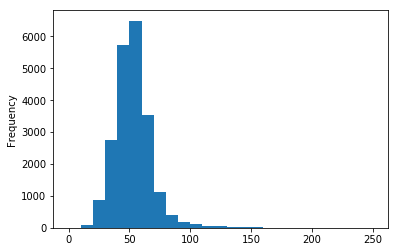

In [209]:
test_len = df.apply(lambda x: len(x["embed"]),axis=1)
test_len.plot.hist(bins=range(0,260,10))

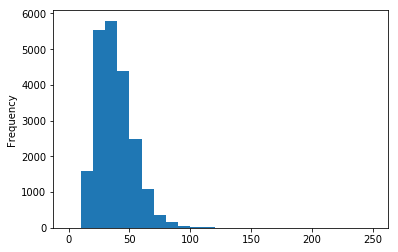

In [210]:
sent_lens = df.apply(lambda x: [len(sent) for sent in x["embed"]],axis=1)
max_sent_len = sent_lens.apply(lambda x: np.max(x))
max_sent_len.plot.hist(bins=range(0,260,10))

In [211]:
def embed_padding(embed,max_sent,max_word,embed_size):
    result = np.zeros((max_sent,max_word,embed_size))
    for sent_ind,sent in enumerate(embed[:max_sent]):
        for word_ind,word in enumerate(sent[:max_word]):
            result[sent_ind,word_ind] = word
    return result

In [215]:
df["embed_pad"] = df.apply(
        lambda x: embed_padding(
            x["embed"],
            100,
            100,
            50),
        axis=1)

In [150]:
#np.save('/data/ts_cost_function/embed_pad.npy', df["embed_pad"])
#Result: Memory Error

In [149]:
#arrays = np.stack(df["embed_pad"].values)
#Result: Memory Error

In [70]:
def define_word_embed_input_fn(df,batch_size,epochs):

    return tf.estimator.inputs.pandas_input_fn(
        df[["#nouns"]],
        y=df["regression_score"],
        batch_size=batch_size,
        num_epochs=epochs,
        shuffle=False,
        queue_capacity=1000,
        num_threads=1,
        target_column="regression_score"
    )

In [72]:
func = define_word_embed_input_fn(df,10,1)
features_op, labels_op = func()
with tf.Session() as sess:
    # initialise and start the queues.
    sess.run(tf.local_variables_initializer())

    coordinator = tf.train.Coordinator()
    _ = tf.train.start_queue_runners(coord=coordinator)

    print(sess.run([features_op, labels_op]))

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InternalError'>, Unable to get element as bytes.


OutOfRangeError: FIFOQueue '_29_enqueue_input_9/fifo_queue' is closed and has insufficient elements (requested 10, current size 0)
	 [[Node: fifo_queue_DequeueUpTo_3 = QueueDequeueUpToV2[component_types=[DT_INT64, DT_DOUBLE, DT_DOUBLE], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](enqueue_input_9/fifo_queue, fifo_queue_DequeueUpTo_3/n)]]

Caused by op 'fifo_queue_DequeueUpTo_3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-8da7294b7876>", line 2, in <module>
    features_op, labels_op = func()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/inputs/pandas_io.py", line 114, in input_fn
    features = queue.dequeue_up_to(batch_size)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/data_flow_ops.py", line 527, in dequeue_up_to
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 3644, in queue_dequeue_up_to_v2
    component_types=component_types, timeout_ms=timeout_ms, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): FIFOQueue '_29_enqueue_input_9/fifo_queue' is closed and has insufficient elements (requested 10, current size 0)
	 [[Node: fifo_queue_DequeueUpTo_3 = QueueDequeueUpToV2[component_types=[DT_INT64, DT_DOUBLE, DT_DOUBLE], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](enqueue_input_9/fifo_queue, fifo_queue_DequeueUpTo_3/n)]]


In [416]:
def word_embed_generator(df):
    for ind,row in df.iterrows():
        yield (row["embed_pad"],row["regression_score"])

In [394]:
np.zeros((5))

array([0., 0., 0., 0., 0.])

In [401]:
a = np.zeros((5,5))
b = np.zeros((5,5))
c = np.zeros((5,5))
np.stack([a,b,c]).shape

(3, 5, 5)

In [439]:
def train_word_emb_fn(df,batch_size,max_sent,max_word,embed_size):
    
    #dataset = tf.data.Dataset.from_tensor_slices((dict(df["embed_pad"]), df["regression_score"]))

    dataset = tf.data.Dataset.from_generator(lambda: 
                                             word_embed_generator(df), 
                                             (tf.float64, tf.float64), 
                                             (tf.TensorShape([max_sent,max_word,embed_size]),
                                             tf.TensorShape([])))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.repeat().batch(batch_size)#.shuffle(1000).repeat().batch(batch_size)
    #shuffle(1000)
    
    # Return the dataset.
    return dataset

In [424]:
dataset = train_word_emb_fn(df,10,100,100,50)

In [425]:
dataset_iter = dataset.make_one_shot_iterator()

In [426]:
sess = tf.Session()
result = sess.run(dataset_iter.get_next())

In [427]:
result[0].shape

(10, 100, 100, 50)

In [ ]:
def eval_word_emb_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

## Sentence Words

## Character Level

# NN Architecture

## Embedding + Sentence RNN + Text RNN

The sentence RNN will output a hidden state for each sentence. Afterwards each hidden state will be used as a input for another RNN on text level. The final output is than the score.

In [372]:
result[0].shape

(10, 100, 100, 50)

In [445]:
sess = tf.Session()
#word_mask = sess.run(tf.reduce_max(tf.count_nonzero(tf.reshape(result[0],[1000,100,50]), 1),1))
sent_mask = sess.run(tf.count_nonzero(tf.reduce_max(tf.count_nonzero(result[0], 2),2), 1))

sent_mask

array([49, 21, 45, 73, 53, 52, 47, 29, 95, 41])

In [522]:
def model_emb_rnn_rnn_fn(features, labels, mode):
    
    
    #word_mask = tf.reduce_max(tf.count_nonzero(result[0], 2),2)
    word_mask = tf.reduce_max(tf.count_nonzero(tf.reshape(features,[1000,100,50]), 1),1)
    #sent_mask = tf.count_nonzero(word_mask, 1)
    sent_mask = tf.count_nonzero(tf.reduce_max(tf.count_nonzero(result[0], 2),2), 1)

    concat_sents = tf.reshape(features,[1000,100,50])
    
    #init_state = tf.cells.zero_state(batch_size, tf.float32)
    with tf.variable_scope('word_cell'):
        word_cell = tf.contrib.rnn.BasicLSTMCell(num_units=64, state_is_tuple=True)
        word_outputs, word_last_states = tf.nn.dynamic_rnn(
            cell=word_cell,
            dtype=tf.float64,
            sequence_length=word_mask,
            #initial_state=init_state,
            inputs=concat_sents)
        
        reshaped_word_last_states = tf.reshape(word_last_states.c,[10,100,64])
        
    with tf.variable_scope('sent_cell'):
        sent_cell = tf.contrib.rnn.BasicLSTMCell(num_units=64, state_is_tuple=False)
        sent_outputs, sent_last_states = tf.nn.dynamic_rnn(
            cell=sent_cell,
            dtype=tf.float64,
            sequence_length=sent_mask,
            inputs=reshaped_word_last_states)
    
    #text_output = tf.contrib.layers.fully_connected(sent_last_states,1)
    pred_value = tf.layers.dense(inputs=sent_last_states, units=1, activation=None)
    
    reshaped_labels = tf.reshape(labels,[10,1])
    
    cost = tf.losses.mean_squared_error(reshaped_labels,pred_value)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "logits": pred_value,
        "loss":cost
    }
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(
            learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=cost,
            global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            loss=cost,
            train_op=train_op)
    

## Embedding + Conv + RNN

Taghipour, Kaveh, and Hwee Tou Ng. "A neural approach to automated essay scoring." Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing. 2016.

![alt text](A_Neural_Approach_to_Automated_Essay_Scoring.PNG)

In [ ]:
#Estimator

## 1D Conv Layer for Text Embedding


## Recurrent Layer with each Conv Layer Output as Input
## Output: Score

## Mean over time of all RNN scores

## Training

In [523]:
tf.reset_default_graph()
model_emb_rnn_rnn = tf.estimator.Estimator(
    model_fn=model_emb_rnn_rnn_fn, model_dir="/data/ts_cost_function/model_emb_rnn_rnn")


#tensors_to_log = {"probabilities": "softmax_tensor"}
#logging_hook = tf.train.LoggingTensorHook(
#  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_task_type': 'worker', '_master': '', '_train_distribute': None, '_service': None, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_session_config': None, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_model_dir': '/data/ts_cost_function/model_emb_rnn_rnn', '_num_ps_replicas': 0, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f35202931d0>, '_is_chief': True}


In [524]:

model_emb_rnn_rnn.train(
    input_fn=lambda:train_word_emb_fn(
        df,10,100,100,50),
    steps=10,)
    #hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:loss = 0.1952132, step = 0
INFO:tensorflow:Saving checkpoints for 10 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:Loss for final step: 0.101836614.


In [464]:
tf.reshape(word_last_states.c,[10,100,64])

<tf.Tensor 'Reshape_4:0' shape=(10, 100, 64) dtype=float64>

## Evaluation

In [ ]:
eval_results = mnist_classifier.evaluate(
    input_fn=lambda:eval_input_fn(X_test,y_test,len(X_test)))